# Load External Lib For nlp bitcoin analysis

In [372]:
# Tensorflow for machine learning
import tensorflow as tf
import swifter
# Numpy and pandas for dataset manipulation
import numpy as np
import pandas as pd
#Seaborn and matplotlib to make graphics 
import seaborn as sns
import matplotlib.pyplot as plt

#Skelarn metrics to get confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Define methods to create dataset and analyze results

#### Create random dataset X, Y with different lenght

In [175]:

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    return df_sample

def split_subsample_sequence(df, length,y):
    '''Create one single random (X,y) pair'''
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1][y]
    X_sample = df_subsample[0:length -1].drop(columns=y)
    X_sample = X_sample.values
    return np.array(X_sample), np.array(y_sample)

def get_X_y_random(df, n_sequences, length, y_class):
    '''Return a list of samples (X, y)'''
    X, y = [], []
    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length,y_class)
        X.append(xi)
        y.append(yi)
    X = np.array(X)
    y = np.array(y)
    return X, y

### Create continous dataset X, Y with same lenght

In [85]:
def get_X_y_same(dataframe, x_number_data,  step, y_class):
    ''' Return a continuous dataset X y with X_number of data in row of x and y'''
    x= []
    y= []

    for i in range(0,len(dataframe)-x_number_data,step):
        
        x.append(dataframe.iloc[i:i+x_number_data].to_numpy())
        y.append(dataframe[y_class].iloc[i+x_number_data])
        
    return np.array(x) , np.array(y)

### Check confusion matrix and learning curves

In [395]:
def plot_get_conf_learning(model,history, X_test, y_test ):
    
    # Predict class for X_test
    predictions = model.predict(X_test)
    # Affect class
    y_mean_pred = [1 * (x[0]>=0.5) for x in predictions]
    # Create confusion matrix
    cf_matrix = confusion_matrix( y_test, y_mean_pred)

    #Create subplot
    fig, axes = plt.subplots(1, 2,  figsize=(15,4))

    # Confusion matrix plotting
    axes[0].set_title(' Confusion Matrix with labels\n\n');
    sns.heatmap(ax =axes[0], data = cf_matrix, annot=True, cmap='Reds')


    # Learning curves plotting
    loss = history.history["loss"]
    loss_val = history.history["val_loss"]
    sns.lineplot(ax=axes[1],data =[loss,loss_val])
    axes[1].set_title('Learning curves \n\n')
    axes[1].legend(labels=["Train set","Test set"], title = "Learning curves")
    
    #Print classification report
    print(classification_report(y_test, y_mean_pred))
    #Show graphics
    return plt.show()


# Load, process and merge bitcoin and reddit dataset

### Load 

In [240]:
#Load daily aggregation of reddit sentimental analysis dataset
daily_reddit = pd.read_csv("data_reddit_btc/reddit_day.csv")

#Load bitcoin daily analysis dataset
daily_btc = pd.read_csv("data_reddit_btc/DatasetChrisDaily.csv")

In [242]:
# Show daily_btc database
daily_btc.head()

,Unnamed: 0,Date,High,Low,Open,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,tenkan_sen_shifted,kijun_sen_shifted,chikou_shifted,close_shifted,indice
0,0,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,NaN,NaN,NaN,NaN,131.979996,NaN,NaN,12.559998,0,0,0,NaN,NaN,NaN,NaN,0
1,1,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,NaN,NaN,NaN,NaN,133.479996,NaN,NaN,5.520004,0,0,0,NaN,NaN,NaN,NaN,0
2,2,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,NaN,NaN,NaN,NaN,129.744995,NaN,NaN,-12.754997,0,0,0,NaN,NaN,NaN,NaN,0
3,3,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,NaN,NaN,NaN,NaN,129.000000,NaN,NaN,-23.790001,0,0,0,NaN,NaN,NaN,NaN,0
4,4,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,NaN,NaN,NaN,NaN,132.300003,NaN,NaN,-34.550003,0,0,0,NaN,NaN,NaN,NaN,0


### Process 

In [239]:
# Check btc dataset keys
print(daily_btc.keys())

#Drop no necessary keys
daily_btc.drop(columns=['Unnamed: 0',  'tenkan_sen_shifted',
       'kijun_sen_shifted', 'chikou_shifted', 'close_shifted'], inplace=True)

daily_btc.head()

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'tenkan_sen',
       'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span',
       'diff_kijun', 'diff_tenkan', 'diff_chikou', 'kijun_signal',
       'tenkan_signal', 'chikou_signal', 'indice'],
      dtype='object')


KeyError: "['Unnamed: 0', 'tenkan_sen_shifted', 'kijun_sen_shifted', 'chikou_shifted', 'close_shifted'] not found in axis"

### Merge

In [38]:
# Inner Merge bitcoin and reddit Dataset to keep only the existing continuous date
daily_BR = daily_reddit.merge(daily_btc, how='inner', left_on='date', right_on='Date').copy()

# Convert date in pd.datetime format
daily_BR["date_time"]=pd.to_datetime(daily_BR["date"],format='%Y-%m-%d')  

# Sort values on date_time
daily_BR =daily_BR.sort_values(by="date_time")

#Check data
daily_BR.head()

,date,score_mean,score_std,score_sum,score_max,v_neg_mean,v_neg_std,v_neg_sum,v_neg_max,v_neu_mean,v_neu_sum,v_neu_std,v_neu_max,v_pos_mean,v_pos_std,v_pos_sum,v_pos_max,v_compound_mean,v_compound_std,v_compound_sum,v_compound_max,t_pol_mean,t_pol_std,t_pol_sum,t_pol_max,t_sub_mean,t_sub_std,t_sub_sum,t_sub_max,v_neu_score_mean,v_neu_score_sum,v_neu_score_std,v_neu_score_max,v_pos_score_mean,v_pos_score_std,v_pos_score_sum,v_pos_score_max,v_compound_score_mean,v_compound_score_std,v_compound_score_sum,v_compound_score_max,t_pol_score_mean,t_pol_score_std,t_pol_score_sum,t_pol_score_max,t_sub_score_mean,t_sub_score_std,t_sub_score_sum,t_sub_score_max,v_neg_score_mean,v_neg_score_std,v_neg_score_sum,v_neg_score_max,date_count,Date,High,Low,Open,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,indice,date_time
0,2017-01-01,4.095483,8.406436,3989.0,116.0,0.061278,0.074932,59.685,0.674,0.829154,807.596,0.108736,1.0,0.109578,0.091042,106.729,0.579,0.247951,0.550243,241.5044,0.9984,0.102978,0.202279,100.300454,1.0,0.447966,0.221794,436.318864,1.0,3.703236,3606.952,6.537687,92.950,0.540065,1.899358,526.023,37.584,0.936370,4.894707,912.0243,40.8155,0.470360,1.918625,458.130558,24.70000,1.890892,3.280482,1841.728790,32.400000,0.285408,0.883918,277.987,17.050,974,2017-01-01,1003.080017,958.698975,963.658020,998.325012,147775008.0,932.752014,881.415009,745.597763,704.654510,919.750000,116.910004,65.572998,78.575012,1,1,1,0,2017-01-01
1,2017-01-02,7.143617,44.739341,20145.0,1859.0,0.061524,0.067844,173.499,0.531,0.829861,2340.209,0.101984,1.0,0.108612,0.087565,306.287,0.674,0.240968,0.569902,679.5298,0.9997,0.095610,0.186729,269.620143,1.0,0.444555,0.214772,1253.644989,1.0,6.206413,17502.086,39.521719,1713.998,0.852863,5.131474,2405.074,128.940,2.127162,25.927811,5998.5965,1124.5091,0.878903,9.536864,2478.505829,290.46875,3.178987,19.136392,8964.742385,826.867708,0.412010,2.455393,1161.867,71.424,2820,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,222184992.0,946.907013,898.401001,746.116516,704.654510,921.590027,123.348999,74.842987,100.159973,1,1,1,0,2017-01-02
2,2017-01-03,5.862605,29.575341,9814.0,570.0,0.060374,0.071586,101.066,0.579,0.830037,1389.482,0.104272,1.0,0.109590,0.087896,183.454,0.636,0.258877,0.560860,433.3606,0.9987,0.101119,0.209033,169.272860,1.0,0.451831,0.216360,756.365240,1.0,4.851201,8120.911,22.470165,457.140,0.810440,7.089782,1356.676,189.144,0.912777,15.705079,1527.9880,240.2550,1.087970,17.264859,1821.262586,456.00000,2.816607,15.955071,4714.999394,399.000000,0.404212,3.511884,676.651,110.028,1674,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,185168000.0,970.488983,904.745972,746.543015,704.654510,919.495972,139.093994,73.350983,124.343994,1,1,1,0,2017-01-03
3,2017-01-04,4.271773,17.128804,8142.0,599.0,0.065616,0.073589,125.065,0.582,0.824412,1571.329,0.106123,1.0,0.109981,0.090355,209.624,0.735,0.227197,0.575732,433.0382,0.9998,0.100390,0.206345,191.342678,1.0,0.458361,0.207941,873.635908,1.0,3.674829,7004.225,13.556661,460.631,0.504505,2.465480,961.587,68.885,0.787692,7.153452,1501.3400,182.1425,0.361828,3.057769,689.644645,76.87500,1.916536,4.794911,3652.918407,110.797619,0.338716,1.856071,645.592,68.885,1906,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,344945984.0,1031.837524,962.416016,752.111511,704.654510,920.382019,192.313965,122.892456,234.347961,1,1,1,0,2017-01-04
4,2017-01-05,3.549738,8.126814,6102.0,146.0,0.060350,0.072556,103.742,0.565,0.832056,1430.305,0.109600,1.0,0.107598,0.092280,184.961,0.627,0.244085,0.552156,419.5827,0.9984,0.105134,0.199678,180.724524,1.0,0.436922,0.229343,751.068731,1.0,2.987909,5136.216,5.895492,89.270,0.456131,2.164643,784.089,61.320,0.760354,5.255419,1307.0479,104.6719,0.445339,3.005284,765.537930,102.20000,1.685690,4.534309,2897.701636,87.600000,0.256962,0.913094,441.718,16.800,1719,2017-01-05,1191.099976,910.416992,1156.729980,1013.3

# Prepare different dataset to start deep learning prediction

### Features selection

In [243]:
# Reddit sentimental analysis aggregation score of vader and textblob of the day by mean > dataset
mean_br_df = daily_BR[[ 'score_mean', 
       'v_neg_mean','v_neu_mean',
       'v_pos_mean','v_compound_mean', 't_pol_mean', 't_sub_mean',
        'High', 'Low', 'Open', 'Close', 'Volume']].copy()

# Reddit sentimental analysis aggregation score of vader and textblob of the day by std > dataset
std_br_df = daily_BR[[ 'score_std', 
       'v_neg_std','v_neu_std',
       'v_pos_std','v_compound_std', 't_pol_std', 't_sub_std',
        'High', 'Low', 'Open', 'Close', 'Volume']].copy()

# Reddit sentimental analysis aggregation score of vader and textblob of the day by max > dataset
max_br_df = daily_BR[[ 'score_max', 
       'v_neg_max','v_neu_max',
       'v_pos_max','v_compound_max', 't_pol_max', 't_sub_max',
        'High', 'Low', 'Open', 'Close', 'Volume']].copy()

### Prepare the predict column Y define as Class,  1 if Close of the day is superior to the Open of the day else -1

In [244]:
# Predict column for mean dataset
mean_br_df["class"]= mean_br_df[["Close","Open"]].swifter.apply(lambda x: 1 if x.Close > x.Open else 0, axis=1)
# Predict column for std dataset
std_br_df["class"]= std_br_df[["Close","Open"]].swifter.apply(lambda x: 1 if x.Close > x.Open else 0, axis=1)
# Predict column for max dataset
max_br_df["class"]= max_br_df[["Close","Open"]].swifter.apply(lambda x: 1 if x.Close > x.Open else 0, axis=1)

Pandas Apply: 100%|██████████| 1095/1095 [00:00<00:00, 60714.69it/s]


### Create X, Y subsample for different agg function of reddit sentimental scores

In [286]:
# X an y for the mean analysis
X_mean,y_mean =get_X_y_random(mean_br_df, 4000,5,"class")
# X an y for the sstd analysis
X_std,y_std =get_X_y_random(std_br_df, 4000,5,"class")
# X an y for the max analysis
X_max,y_max =get_X_y_random(max_br_df, 4000,5,"class")

### Method to convert a list of y predict to a list of list of y predict 

In [246]:
# def reshape_y(y):
#     '''Reshape y for cnn convention
#     Get a list return a list of list
#     '''
#     return y.reshape(y.shape[0],1)

# # Reshape predict list values
# y_mean = reshape_y(y_mean)
# y_std = reshape_y(y_std)
# y_max = reshape_y(y_max)

### Train test separation

In [287]:

# from sklearn.utils import shuffle
# X, y = shuffle(X, y, random_state=4)

train_size = 2300

#mean dataset
X_mean_train = X_mean[:train_size]
X_mean_test = X_mean[train_size:]
y_mean_train = y_mean[:train_size]
y_mean_test=y_mean[train_size:]

#std dataset
X_std_train = X_std[:train_size]
X_std_test = X_std[train_size:]
y_std_train = y_std[:train_size]
y_std_test =y_std[train_size:]

#max dataset
X_max_train = X_max[:train_size]
X_max_test = X_max[train_size:]
y_max_train = y_max[:train_size]
y_max_test=y_max[train_size:]

#Test shape of train and test
print(X_max_train.shape, X_max_test.shape, y_max_train.shape, y_max_test.shape)

(2300, 4, 12) (1700, 4, 12) (2300,) (1700,)


### Check the balanced of binary class in created datasets

Text(0.5, 1.0, 'max y train distribution')

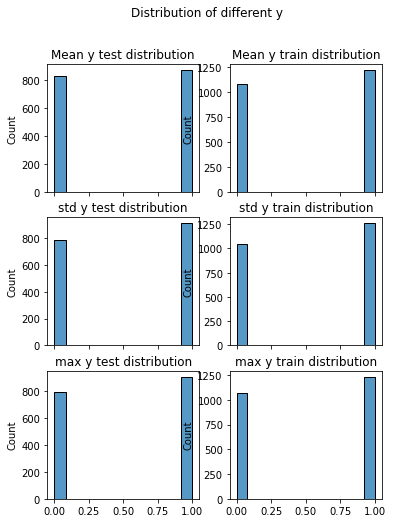

In [380]:
# Check the balanced of y pred dataset
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(6,8))
fig.suptitle('Distribution of different y ')

# Y Mean test
sns.histplot(ax=axes[0][0], data=y_mean_test)
axes[0][0].set_title("Mean y test distribution")

# Y Std test
sns.histplot(ax=axes[1][0], data=y_std_test, )
axes[1][0].set_title("std y test distribution")

# Y max test
sns.histplot(ax=axes[2][0], data=y_max_test, )
axes[2][0].set_title("max y test distribution")

# Y Mean train
sns.histplot(ax=axes[0][1], data=y_mean_train)
axes[0][1].set_title("Mean y train distribution")

# Y Std train
sns.histplot(ax=axes[1][1], data=y_std_train, )
axes[1][1].set_title("std y train distribution")

# Y max train
sns.histplot(ax=axes[2][1], data=y_max_train, )
axes[2][1].set_title("max y train distribution")

# Daily analysis lstm with a simple model

In [413]:
# Import tensor flow to create neural network lstm
from tensorflow.keras import layers
from tensorflow.keras import models

def init_model(X):
    model = models.Sequential()
    neurons = 16
    model.add(layers.LSTM(neurons,return_sequences=True, input_shape=(X.shape[1],X.shape[2] )))
    model.add(layers.LSTM(8, input_shape=(X.shape[1],X.shape[2] )))
    model.add(layers.Dense(4, activation='linear'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])
    return model

## First exploration experiments

### Mean scores and technical features (with ichimoku)

#### Train neural network

In [311]:
# Impor tensorflow early stopping callback to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model_mean_v1 = init_model(X_mean_train)
#Define early stopping parmaters
es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')

#Start training the neural network
history_mean_v1 = model_mean_v1.fit(X_mean_train, y_mean_train, 
          epochs=250, 
          batch_size=2, 
          verbose=1, 
          callbacks=es,
          validation_split=0.2)

Epoch 1/250
920/920 [==============================] - 3s 1ms/step - loss: 0.7152 - accuracy: 0.4989 - val_loss: 0.6923 - val_accuracy: 0.5152
Epoch 2/250
920/920 [==============================] - 1s 1ms/step - loss: 0.7010 - accuracy: 0.4967 - val_loss: 0.6869 - val_accuracy: 0.5196
Epoch 3/250
920/920 [==============================] - 1s 1ms/step - loss: 0.6879 - accuracy: 0.5375 - val_loss: 0.6847 - val_accuracy: 0.5587
Epoch 4/250
920/920 [==============================] - 1s 1ms/step - loss: 0.6893 - accuracy: 0.5451 - val_loss: 0.6853 - val_accuracy: 0.5630
Epoch 5/250
920/920 [==============================] - 1s 1ms/step - loss: 0.6893 - accuracy: 0.5408 - val_loss: 0.6859 - val_accuracy: 0.5478
Epoch 6/250
920/920 [==============================] - 1s 1ms/step - loss: 0.6864 - accuracy: 0.5467 - val_loss: 0.6863 - val_accuracy: 0.5478
Epoch 7/250
920/920 [==============================] - 1s 1ms/step - loss: 0.6853 - accuracy: 0.5375 - val_loss: 0.6864 - val_accuracy: 0.5478

#### Model mean version 1 analysis

              precision    recall  f1-score   support

         0.0       0.55      0.50      0.52       827
         1.0       0.56      0.61      0.58       873

    accuracy                           0.56      1700
   macro avg       0.56      0.55      0.55      1700
weighted avg       0.56      0.56      0.55      1700



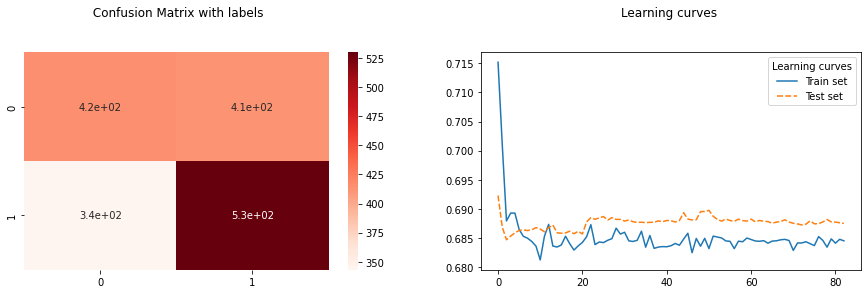

In [397]:
plot_get_conf_learning(model_mean_v1,history_mean_v1,X_mean_test, y_mean_test)

### Std scores and technical features (with ichimoku)

#### Train neural network

In [405]:
model_std_v1 = init_model(X_std_train)
# Define early stopping parameters
es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')

#Train the model
history_std_v1 = model_std_v1.fit(X_std_train, y_std_train, 
          epochs=250, 
          batch_size=2, 
          verbose=2, 
          callbacks=es,
          validation_split=0.2)

Epoch 1/250
920/920 - 3s - loss: 0.6880 - accuracy: 0.5380 - val_loss: 0.6776 - val_accuracy: 0.5913
Epoch 2/250
920/920 - 1s - loss: 0.6845 - accuracy: 0.5549 - val_loss: 0.6742 - val_accuracy: 0.5957
Epoch 3/250
920/920 - 2s - loss: 0.6831 - accuracy: 0.5451 - val_loss: 0.6775 - val_accuracy: 0.5239
Epoch 4/250
920/920 - 1s - loss: 0.6824 - accuracy: 0.5576 - val_loss: 0.6735 - val_accuracy: 0.5957
Epoch 5/250
920/920 - 2s - loss: 0.6828 - accuracy: 0.5603 - val_loss: 0.6771 - val_accuracy: 0.5978
Epoch 6/250
920/920 - 1s - loss: 0.6820 - accuracy: 0.5522 - val_loss: 0.6749 - val_accuracy: 0.6022
Epoch 7/250
920/920 - 1s - loss: 0.6829 - accuracy: 0.5549 - val_loss: 0.6742 - val_accuracy: 0.6000
Epoch 8/250
920/920 - 2s - loss: 0.6832 - accuracy: 0.5582 - val_loss: 0.6723 - val_accuracy: 0.6022
Epoch 9/250
920/920 - 2s - loss: 0.6821 - accuracy: 0.5674 - val_loss: 0.6736 - val_accuracy: 0.6000
Epoch 10/250
920/920 - 1s - loss: 0.6813 - accuracy: 0.5663 - val_loss: 0.6747 - val_accura

#### Model std version 1 analysis

              precision    recall  f1-score   support

         0.0       0.69      0.12      0.20       788
         1.0       0.56      0.96      0.70       912

    accuracy                           0.57      1700
   macro avg       0.62      0.54      0.45      1700
weighted avg       0.62      0.57      0.47      1700



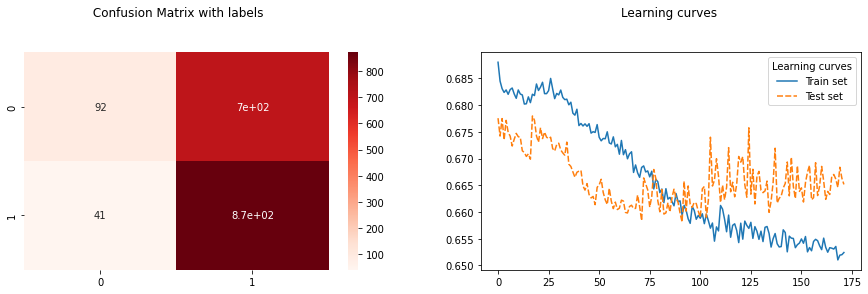

In [410]:
plot_get_conf_learning(model_std_v1,history_std_v1,X_std_test, y_std_test)

### Max scores and technical features (with ichimoku)

#### Train neural network

In [385]:
model_max = init_model(X_max_train)

es = EarlyStopping(patience=70, restore_best_weights=True,monitor='val_loss')
history_max_v1 = model_max.fit(X_max_train, y_max_train, 
          epochs=250, 
          batch_size=2, 
          verbose=1, 
          callbacks=es,
          validation_split=0.2)

Epoch 1/250
920/920 [==============================] - 4s 2ms/step - loss: 0.6948 - accuracy: 0.5168 - val_loss: 0.6939 - val_accuracy: 0.5217
Epoch 2/250
920/920 [==============================] - 2s 2ms/step - loss: 0.6891 - accuracy: 0.5473 - val_loss: 0.6941 - val_accuracy: 0.5217
Epoch 3/250
920/920 [==============================] - 2s 2ms/step - loss: 0.6896 - accuracy: 0.5375 - val_loss: 0.6922 - val_accuracy: 0.5261
Epoch 4/250
920/920 [==============================] - 2s 2ms/step - loss: 0.6889 - accuracy: 0.5266 - val_loss: 0.6916 - val_accuracy: 0.5261
Epoch 5/250
920/920 [==============================] - 2s 2ms/step - loss: 0.6870 - accuracy: 0.5370 - val_loss: 0.6949 - val_accuracy: 0.5261
Epoch 6/250
920/920 [==============================] - 2s 2ms/step - loss: 0.6879 - accuracy: 0.5408 - val_loss: 0.6909 - val_accuracy: 0.5304
Epoch 7/250
920/920 [==============================] - 2s 2ms/step - loss: 0.6889 - accuracy: 0.5408 - val_loss: 0.6903 - val_accuracy: 0.5304

#### Model max version 1 analysis

              precision    recall  f1-score   support

         0.0       0.65      0.16      0.25       794
         1.0       0.56      0.93      0.69       906

    accuracy                           0.57      1700
   macro avg       0.60      0.54      0.47      1700
weighted avg       0.60      0.57      0.49      1700



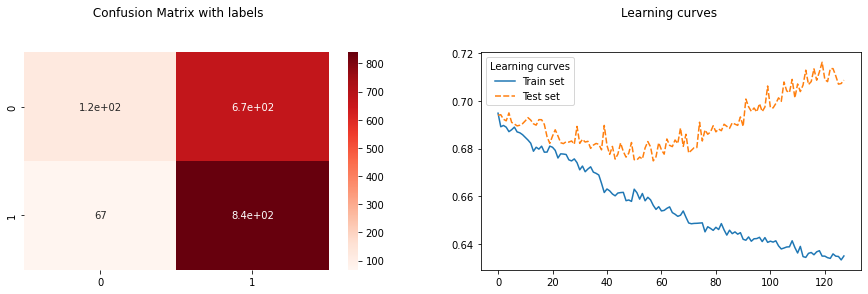

In [409]:
plot_get_conf_learning(model_max,history_max_v1,X_max_test, y_max_test)

### Check differences between three last models

In [414]:
print(f"mean accuracy score:  {model_mean_v1.evaluate(X_mean_test,y_mean_test,verbose=0)[1]}")
print(f"std accuracy score: {model_std_v1.evaluate(X_std_test,y_std_test,verbose=0)[1]}")
print(f"max accuracy score: {model_max.evaluate(X_max_test,y_max_test,verbose=0)[1]}")

mean accuracy score:  0.5558823347091675
std accuracy score: 0.5664705634117126
max accuracy score: 0.5664705634117126


## Second exploration experiment

### Features selection test 1

In [416]:
test_2_mean = daily_BR[['date', 'score_mean', 
       'v_neg_mean','v_neu_mean',
       'v_pos_mean','v_compound_mean', 't_pol_mean', 't_sub_mean',
        'Close'
       ,'class']].copy()

test_2_std = daily_BR[['date', 'score_std', 
       'v_neg_std','v_neu_std',
       'v_pos_std','v_compound_std', 't_pol_std', 't_sub_std',
        'Close'
       ,'class']].copy()

test_2_max = daily_BR[['date', 'score_max', 
       'v_neg_max','v_neu_max',
       'v_pos_max','v_compound_max', 't_pol_max', 't_sub_max',
       'Close'
       ,'class']].copy()

test_2_sum = daily_BR[['date', 'score_sum', 
       'v_neg_sum','v_neu_sum',
       'v_pos_sum','v_compound_sum', 't_pol_sum', 't_sub_sum',
       'Close'
       ,'class']].copy()

KeyError: "['class'] not in index"

In [415]:
X_mean,y_mean =get_X_y_random(test_2_mean.drop(columns="date"), 1500,6)
X2_std,y2_std =get_X_y_random(test_2_std.drop(columns="date"), 1500,6)
X3_max,y3_max =get_X_y_random(test_2_max.drop(columns="date"), 1500,6)
X3_sum,y3_sum =get_X_y_random(test_2_sum.drop(columns="date"), 1500,6)

NameError: name 'test_2_mean' is not defined

In [350]:
from sklearn.utils import shuffle
X_mean, y_mean = shuffle(X_mean, y_mean, random_state=4)
X2_std, y2_std = shuffle(X2_std, y2_std, random_state=4)
X3_max, y3_max = shuffle(X3_max, y3_max, random_state=4)
X3_sum, y3_sum = shuffle(X3_sum, y3_sum, random_state=4)


In [397]:
train_size = 1200


X_train_2 = X_mean[:train_size]
X_test_2 = X_mean[train_size:]
y_train_2 = y_mean[:train_size]
y_test_2=y_mean[train_size:]

#std
X_train_std_2 = X2_std[:train_size]
X_test_std_2 = X2_std[train_size:]
y_train_std_2 = y2_std[:train_size]
y_test_std_2 =y2_std[train_size:]

#max
X_train_max_2 = X3_max[:train_size]
X_test_max_2 = X3_max[train_size:]
y_train_max_2 = y3_max[:train_size]
y_test_max_2=y3_max[train_size:]

#sum
X_train_sum_2 = X3_sum[:train_size]
X_test_sum_2 = X3_sum[train_size:]
y_train_sum_2 = y3_sum[:train_size]
y_test_sum_2=y3_sum[train_size:]


In [353]:
def init_model():
    model = models.Sequential()
    neurons = 32

    model.add(layers.LSTM(neurons,input_shape=(X_mean.shape[1],X_mean.shape[2] ), activation="tanh"))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])
   
    return model

In [363]:
from tensorflow.keras.callbacks import EarlyStopping
model_mean_3 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_mean_3 = model_mean_3.fit(X_train_2, y_train_2, 
          epochs=500, 
          batch_size=4, 
          verbose=1, 
          callbacks=[es],
          validation_split=0.3)

Epoch 1/500
210/210 [==============================] - 1s 3ms/step - loss: 0.6867 - accuracy: 0.5607 - val_loss: 0.6977 - val_accuracy: 0.5139
Epoch 2/500
210/210 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5702 - val_loss: 0.7006 - val_accuracy: 0.5139
Epoch 3/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6845 - accuracy: 0.5702 - val_loss: 0.6999 - val_accuracy: 0.5139
Epoch 4/500
210/210 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5702 - val_loss: 0.7010 - val_accuracy: 0.5139
Epoch 5/500
210/210 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.5702 - val_loss: 0.7030 - val_accuracy: 0.5139
Epoch 6/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6842 - accuracy: 0.5702 - val_loss: 0.6978 - val_accuracy: 0.5139
Epoch 7/500
210/210 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5702 - val_loss: 0.6976 - val_accuracy: 0.5139

In [355]:
from tensorflow.keras.callbacks import EarlyStopping
model_std_3 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_std_3 = model_std_3.fit(X_train_std_2, y_train_std_2, 
          epochs=500, 
          batch_size=2, 
          verbose=1, 
          callbacks=[es,tensorboard_callback],
          validation_split=0.2)

Epoch 1/500
  1/480 [..............................] - ETA: 5:32 - loss: 0.7000 - accuracy: 0.5000

2022-06-08 21:44:17.556911: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-08 21:44:17.556927: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 79/480 [===>..........................] - ETA: 3s - loss: 0.6937 - accuracy: 0.5316

2022-06-08 21:44:17.961989: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-08 21:44:17.964346: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-08 21:44:17.966668: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_21_44_17
2022-06-08 21:44:17.968002: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_21_44_17/MacBook-Air-de-christopher.local.trace.json.gz
2022-06-08 21:44:17.969994: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_21_44_17
2022-06-08 21:44:17.970105: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/fit9/20220

480/480 [==============================] - 2s 4ms/step - loss: 0.6884 - accuracy: 0.5552 - val_loss: 0.6991 - val_accuracy: 0.4750
Epoch 2/500
480/480 [==============================] - 1s 3ms/step - loss: 0.6902 - accuracy: 0.5562 - val_loss: 0.7151 - val_accuracy: 0.4750
Epoch 3/500
480/480 [==============================] - 2s 3ms/step - loss: 0.6896 - accuracy: 0.5562 - val_loss: 0.7026 - val_accuracy: 0.4750
Epoch 4/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6905 - accuracy: 0.5562 - val_loss: 0.7044 - val_accuracy: 0.4750
Epoch 5/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6896 - accuracy: 0.5562 - val_loss: 0.7084 - val_accuracy: 0.4750
Epoch 6/500
480/480 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.5500 - val_loss: 0.7145 - val_accuracy: 0.4750
Epoch 7/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6890 - accuracy: 0.5562 - val_loss: 0.7025 - val_accuracy: 0.4750
Epoch 8/500

In [356]:
from tensorflow.keras.callbacks import EarlyStopping
model_max_3 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_max_3 = model_max_3.fit(X_train_max_2, y_train_max_2, 
          epochs=500, 
          batch_size=2, 
          verbose=1, 
          callbacks=[es,tensorboard_callback],
          validation_split=0.2)

Epoch 1/500
103/480 [=====>........................] - ETA: 0s - loss: 0.6839 - accuracy: 0.5680

2022-06-08 21:45:23.262934: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-08 21:45:23.262951: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-08 21:45:23.299785: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-08 21:45:23.302069: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-08 21:45:23.303937: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_21_45_23
2022-06-08 21:45:23.305267: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_21_45_23/MacBook-Air-de-christopher.local.trace.json.gz
2022-06-08 21:45:23.307294: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit

480/480 [==============================] - 2s 3ms/step - loss: 0.6934 - accuracy: 0.5240 - val_loss: 0.7002 - val_accuracy: 0.4625
Epoch 2/500
480/480 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.5063 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 3/500
480/480 [==============================] - 1s 3ms/step - loss: 0.6895 - accuracy: 0.5240 - val_loss: 0.6855 - val_accuracy: 0.5583
Epoch 4/500
480/480 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.5323 - val_loss: 0.6829 - val_accuracy: 0.5667
Epoch 5/500
480/480 [==============================] - 1s 2ms/step - loss: 0.6864 - accuracy: 0.5458 - val_loss: 0.6880 - val_accuracy: 0.5625
Epoch 6/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6843 - accuracy: 0.5490 - val_loss: 0.6907 - val_accuracy: 0.4708
Epoch 7/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6839 - accuracy: 0.5240 - val_loss: 0.6940 - val_accuracy: 0.4708
Epoch 8/500

In [357]:
from tensorflow.keras.callbacks import EarlyStopping
model_sum_3 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_sum_3 = model_sum_3.fit(X_train_sum_2, y_train_sum_2, 
          epochs=500, 
          batch_size=2, 
          verbose=1, 
          callbacks=[es,tensorboard_callback],
          validation_split=0.2)

Epoch 1/500
 84/480 [====>.........................] - ETA: 1s - loss: 0.7385 - accuracy: 0.4107

2022-06-08 21:46:25.481113: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-08 21:46:25.481131: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-08 21:46:25.516954: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-08 21:46:25.519385: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-08 21:46:25.521566: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_21_46_25
2022-06-08 21:46:25.523011: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_21_46_25/MacBook-Air-de-christopher.local.trace.json.gz
2022-06-08 21:46:25.525374: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit

480/480 [==============================] - 2s 3ms/step - loss: 0.7023 - accuracy: 0.4708 - val_loss: 0.6830 - val_accuracy: 0.5375
Epoch 2/500
480/480 [==============================] - 1s 3ms/step - loss: 0.6810 - accuracy: 0.5510 - val_loss: 0.7028 - val_accuracy: 0.5083
Epoch 3/500
480/480 [==============================] - 1s 3ms/step - loss: 0.6876 - accuracy: 0.5479 - val_loss: 0.6948 - val_accuracy: 0.5375
Epoch 4/500
480/480 [==============================] - 2s 3ms/step - loss: 0.6875 - accuracy: 0.5542 - val_loss: 0.6901 - val_accuracy: 0.5458
Epoch 5/500
480/480 [==============================] - 1s 3ms/step - loss: 0.6863 - accuracy: 0.5500 - val_loss: 0.6925 - val_accuracy: 0.5250
Epoch 6/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6855 - accuracy: 0.5698 - val_loss: 0.6985 - val_accuracy: 0.5167
Epoch 7/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6855 - accuracy: 0.5469 - val_loss: 0.6892 - val_accuracy: 0.5250
Epoch 8/500

In [442]:
X_train_2, X_test_2, y_train_2, y_test_2,X_train_std_2,X_test_std_2,y_train_std_2,y_test_std_2,\
X_train_max_2,X_test_max_2,y_train_max_2,y_test_max_2,X_train_sum_2,X_test_sum_2,y_train_sum_2,y_test_sum_2\
=create_all_data(test_2_mean,test_2_std,test_2_max,test_2_sum)

In [598]:
print(f"mean score {model_mean_3.evaluate(X_test_2,y_test_2)}")
print(f"std score {model_std_3.evaluate(X_test_std_2,y_test_std_2)}")
print(f" max {model_max_3.evaluate(X_test_max_2,y_test_max_2)}")
print(f" sum {model_sum_3.evaluate(X_test_sum_2,y_test_sum_2)}")

10/10 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5367
mean score [0.6910333037376404, 0.5366666913032532]
10/10 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5333
std score [0.6934347152709961, 0.5333333611488342]
10/10 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5800
 max [0.685415506362915, 0.5799999833106995]
10/10 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.4733
 sum [0.6928543448448181, 0.47333332896232605]


## Test du shift

In [358]:
daily.keys()

Index(['date', 'score_mean', 'score_std', 'score_sum', 'score_max',
       'v_neg_mean', 'v_neg_std', 'v_neg_sum', 'v_neg_max', 'v_neu_mean',
       'v_neu_sum', 'v_neu_std', 'v_neu_max', 'v_pos_mean', 'v_pos_std',
       'v_pos_sum', 'v_pos_max', 'v_compound_mean', 'v_compound_std',
       'v_compound_sum', 'v_compound_max', 't_pol_mean', 't_pol_std',
       't_pol_sum', 't_pol_max', 't_sub_mean', 't_sub_std', 't_sub_sum',
       't_sub_max', 'v_neu_score_mean', 'v_neu_score_sum', 'v_neu_score_std',
       'v_neu_score_max', 'v_pos_score_mean', 'v_pos_score_std',
       'v_pos_score_sum', 'v_pos_score_max', 'v_compound_score_mean',
       'v_compound_score_std', 'v_compound_score_sum', 'v_compound_score_max',
       't_pol_score_mean', 't_pol_score_std', 't_pol_score_sum',
       't_pol_score_max', 't_sub_score_mean', 't_sub_score_std',
       't_sub_score_sum', 't_sub_score_max', 'v_neg_score_mean',
       'v_neg_score_std', 'v_neg_score_sum', 'v_neg_score_max', 'date_count',
       

In [421]:
test_2_mean = daily[['date', 'score_mean', 
       'v_neg_mean','v_neu_mean',
       'v_pos_mean','v_compound_mean', 't_pol_mean', 't_sub_mean',
        'Close'
       ,'class']].copy()

test_2_std = daily[['date', 'score_std', 
       'v_neg_std','v_neu_std',
       'v_pos_std','v_compound_std', 't_pol_std', 't_sub_std',
        'Close'
       ,'class']].copy()

test_2_max = daily[['date', 'score_max', 
       'v_neg_max','v_neu_max',
       'v_pos_max','v_compound_max', 't_pol_max', 't_sub_max',
       'Close'
       ,'class']].copy()

test_2_sum = daily[['date', 'score_sum', 
       'v_neg_sum','v_neu_sum',
       'v_pos_sum','v_compound_sum', 't_pol_sum', 't_sub_sum',
       'Close'
       ,'class']].copy()
test_2_mean

,date,score_mean,v_neg_mean,v_neu_mean,v_pos_mean,v_compound_mean,t_pol_mean,t_sub_mean,Close,class
0,2017-01-01,4.095483,0.061278,0.829154,0.109578,0.247951,0.102978,0.447966,998.325012,1
1,2017-01-02,7.143617,0.061524,0.829861,0.108612,0.240968,0.095610,0.444555,1021.750000,1
2,2017-01-03,5.862605,0.060374,0.830037,0.109590,0.258877,0.101119,0.451831,1043.839966,1
3,2017-01-04,4.271773,0.065616,0.824412,0.109981,0.227197,0.100390,0.458361,1154.729980,1
4,2017-01-05,3.549738,0.060350,0.832056,0.107598,0.244085,0.105134,0.436922,1013.380005,0
...,...,...,...,...,...,...,...,...,...,...
1090,2019-12-27,3.924113,0.065896,0.827884,0.106214,0.192902,0.093764,0.438650,7254.740000,1
1091,2019-12-28,5.111582,0.062417,0.834208,0.103384,0.201651,0.098039,0.430993,7316.140000,1
1092,2019-12-29,4.245443,0.063334,0.829598,0.107070,0.211699,0.094416,0.437290,7388.240000,1
1093,2019-12-30,5.417252,0.061741,0.833728,0.104532,0.230646,0.098488,0.428165,7246.000000,0


In [422]:
test_2_mean[['score_mean', 
       'v_neg_mean','v_neu_mean',
       'v_pos_mean','v_compound_mean', 't_pol_mean', 't_sub_mean']]=test_2_mean[['score_mean', 
       'v_neg_mean','v_neu_mean',
       'v_pos_mean','v_compound_mean', 't_pol_mean', 't_sub_mean',]].shift(periods=-1)
test_2_mean = test_2_mean[0:len(test_2_mean)-1]

test_2_std[['score_std', 
       'v_neg_std','v_neu_std',
       'v_pos_std','v_compound_std', 't_pol_std', 't_sub_std']]=test_2_std[['score_std', 
       'v_neg_std','v_neu_std',
       'v_pos_std','v_compound_std', 't_pol_std', 't_sub_std',]].shift(periods=-1)
test_2_std =test_2_std[0:len(test_2_std)-1]

test_2_max[['score_max', 
       'v_neg_max','v_neu_max',
       'v_pos_max','v_compound_max', 't_pol_max', 't_sub_max']]=test_2_max[['score_max', 
       'v_neg_max','v_neu_max',
       'v_pos_max','v_compound_max', 't_pol_max', 't_sub_max',]].shift(periods=-1)
test_2_max = test_2_max[0:len(test_2_max)-1]

test_2_sum[['score_sum', 
       'v_neg_sum','v_neu_sum',
       'v_pos_sum','v_compound_sum', 't_pol_sum', 't_sub_sum']]=test_2_sum[['score_sum', 
       'v_neg_sum','v_neu_sum',
       'v_pos_sum','v_compound_sum', 't_pol_sum', 't_sub_sum',]].shift(periods=-1)
test_2_sum =test_2_sum[0:len(test_2_sum)-1]


In [435]:
test_2_max

,date,score_max,v_neg_max,v_neu_max,v_pos_max,v_compound_max,t_pol_max,t_sub_max,Close,class
0,2017-01-01,1859.0,0.531,1.0,0.674,0.9997,1.0,1.0,998.325012,1
1,2017-01-02,570.0,0.579,1.0,0.636,0.9987,1.0,1.0,1021.750000,1
2,2017-01-03,599.0,0.582,1.0,0.735,0.9998,1.0,1.0,1043.839966,1
3,2017-01-04,146.0,0.565,1.0,0.627,0.9984,1.0,1.0,1154.729980,1
4,2017-01-05,1755.0,0.508,1.0,0.560,0.9972,1.0,1.0,1013.380005,0
...,...,...,...,...,...,...,...,...,...,...
1089,2019-12-26,207.0,0.600,1.0,0.620,0.9979,1.0,1.0,7202.000000,0
1090,2019-12-27,281.0,0.461,1.0,0.482,0.9988,1.0,1.0,7254.740000,1
1091,2019-12-28,292.0,0.469,1.0,0.502,0.9979,1.0,1.0,7316.140000,1
1092,2019-12-29,522.0,0.753,1.0,0.592,0.9979,1.0,1.0,7388.240000,1


In [436]:
test_2_mean

,date,score_mean,v_neg_mean,v_neu_mean,v_pos_mean,v_compound_mean,t_pol_mean,t_sub_mean,Close,class
0,2017-01-01,7.143617,0.061524,0.829861,0.108612,0.240968,0.095610,0.444555,998.325012,1
1,2017-01-02,5.862605,0.060374,0.830037,0.109590,0.258877,0.101119,0.451831,1021.750000,1
2,2017-01-03,4.271773,0.065616,0.824412,0.109981,0.227197,0.100390,0.458361,1043.839966,1
3,2017-01-04,3.549738,0.060350,0.832056,0.107598,0.244085,0.105134,0.436922,1154.729980,1
4,2017-01-05,6.025253,0.067773,0.827938,0.104296,0.207523,0.095999,0.443516,1013.380005,0
...,...,...,...,...,...,...,...,...,...,...
1089,2019-12-26,3.924113,0.065896,0.827884,0.106214,0.192902,0.093764,0.438650,7202.000000,0
1090,2019-12-27,5.111582,0.062417,0.834208,0.103384,0.201651,0.098039,0.430993,7254.740000,1
1091,2019-12-28,4.245443,0.063334,0.829598,0.107070,0.211699,0.094416,0.437290,7316.140000,1
1092,2019-12-29,5.417252,0.061741,0.833728,0.104532,0.230646,0.098488,0.428165,7388.240000,1


In [428]:
X_train_2, X_test_2, y_train_2, y_test_2,X_train_std_2,X_test_std_2,y_train_std_2,y_test_std_2,\
X_train_max_2,X_test_max_2,y_train_max_2,y_test_max_2,X_train_sum_2,X_test_sum_2,y_train_sum_2,y_test_sum_2\
=create_all_data(test_2_mean,test_2_std,test_2_max,test_2_sum,1500,4)

In [429]:
def init_model():
    model = models.Sequential()
    # model.add(normalizer)
    neurons = 64
    dropout = 0.0002
    activ_func = "linear"

    model.add(layers.LSTM(neurons,input_shape=(X_mean.shape[1],X_mean.shape[2] ), activation="tanh"))
    # model.add(layers.LSTM(neurons, activation="tanh"))

    # model.add(layers.LSTM(neurons, activation="tanh"))

    # model.add(layers.Dropout(dropout))

    # model.add(layers.LSTM(neurons, return_sequences=True, activation=activ_func))
    # model.add(layers.Dropout(dropout))

    # model.add(layers.LSTM(neurons, return_sequences=False, activation=activ_func))
    # model.add(layers.Dropout(dropout))
    # model.add(layers.Dense(16, activation='relu'))
    # model.add(layers.Dropout(dropout))


    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])


    
    return model

In [430]:
from tensorflow.keras.callbacks import EarlyStopping
model_mean_4 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_mean_4 = model_mean_4.fit(X_train_2, y_train_2, 
          epochs=500, 
          batch_size=2, 
          verbose=1, 
          callbacks=[es],
          validation_split=0.2)

Epoch 1/500
480/480 [==============================] - 2s 2ms/step - loss: 0.6942 - accuracy: 0.5177 - val_loss: 0.6951 - val_accuracy: 0.4167
Epoch 2/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6938 - accuracy: 0.5125 - val_loss: 0.6865 - val_accuracy: 0.5833
Epoch 3/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6937 - accuracy: 0.5229 - val_loss: 0.6882 - val_accuracy: 0.5833
Epoch 4/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6939 - accuracy: 0.5229 - val_loss: 0.6864 - val_accuracy: 0.5833
Epoch 5/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6941 - accuracy: 0.5188 - val_loss: 0.6862 - val_accuracy: 0.5833
Epoch 6/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6942 - accuracy: 0.5229 - val_loss: 0.6887 - val_accuracy: 0.5833
Epoch 7/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6936 - accuracy: 0.5146 - val_loss: 0.6898 - val_accuracy: 0.5833

In [431]:
from tensorflow.keras.callbacks import EarlyStopping
model_std_4 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_std_4 = model_std_4.fit(X_train_std_2, y_train_std_2, 
          epochs=500, 
          batch_size=4, 
          verbose=1, 
          callbacks=[es],
          validation_split=0.3)

Epoch 1/500
210/210 [==============================] - 1s 2ms/step - loss: 0.7277 - accuracy: 0.5262 - val_loss: 0.6983 - val_accuracy: 0.4972
Epoch 2/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5119 - val_loss: 0.6944 - val_accuracy: 0.4972
Epoch 3/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5298 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 4/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5286 - val_loss: 0.6936 - val_accuracy: 0.4972
Epoch 5/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5286 - val_loss: 0.6939 - val_accuracy: 0.4972
Epoch 6/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5298 - val_loss: 0.6938 - val_accuracy: 0.4972
Epoch 7/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5036 - val_loss: 0.6969 - val_accuracy: 0.4972

In [432]:
from tensorflow.keras.callbacks import EarlyStopping
model_max_4 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_max_4 = model_max_4.fit(X_train_max_2, y_train_max_2, 
          epochs=500, 
          batch_size=2, 
          verbose=1, 
          callbacks=[es,tensorboard_callback],
          validation_split=0.2)

Epoch 1/500
  3/480 [..............................] - ETA: 51s - loss: 0.6978 - accuracy: 0.5000 

2022-06-08 22:17:40.073581: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-08 22:17:40.073599: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-08 22:17:40.251799: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-08 22:17:40.253543: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-08 22:17:40.255027: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_22_17_40
2022-06-08 22:17:40.256508: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/fit9/20220608-173013/train/plugins/profile/2022_06_08_22_17_40/MacBook-Air-de-christopher.local.trace.json.gz
2022-06-08 22:17:40.258549: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit

480/480 [==============================] - 2s 3ms/step - loss: 0.7058 - accuracy: 0.5250 - val_loss: 0.6826 - val_accuracy: 0.5000
Epoch 2/500
480/480 [==============================] - 1s 2ms/step - loss: 0.6839 - accuracy: 0.5750 - val_loss: 0.6746 - val_accuracy: 0.6042
Epoch 3/500
480/480 [==============================] - 1s 2ms/step - loss: 0.6783 - accuracy: 0.5740 - val_loss: 0.6724 - val_accuracy: 0.6042
Epoch 4/500
480/480 [==============================] - 1s 2ms/step - loss: 0.6801 - accuracy: 0.5656 - val_loss: 0.6786 - val_accuracy: 0.6042
Epoch 5/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6826 - accuracy: 0.5667 - val_loss: 0.6764 - val_accuracy: 0.6000
Epoch 6/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6843 - accuracy: 0.5719 - val_loss: 0.6783 - val_accuracy: 0.6000
Epoch 7/500
480/480 [==============================] - 1s 1ms/step - loss: 0.6821 - accuracy: 0.5688 - val_loss: 0.6727 - val_accuracy: 0.6000
Epoch 8/500

In [433]:
from tensorflow.keras.callbacks import EarlyStopping
model_sum_4 = init_model()

es = EarlyStopping(patience=80, restore_best_weights=True,monitor='val_loss')
history_sum_4 = model_sum_4.fit(X_train_sum_2, y_train_sum_2, 
          epochs=500, 
          batch_size=4, 
          verbose=1, 
          callbacks=[es],
          validation_split=0.3)

Epoch 1/500
210/210 [==============================] - 2s 3ms/step - loss: 0.7150 - accuracy: 0.5024 - val_loss: 0.7074 - val_accuracy: 0.4806
Epoch 2/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.5107 - val_loss: 0.6936 - val_accuracy: 0.5111
Epoch 3/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5310 - val_loss: 0.6905 - val_accuracy: 0.5222
Epoch 4/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6949 - accuracy: 0.5440 - val_loss: 0.6934 - val_accuracy: 0.5111
Epoch 5/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6898 - accuracy: 0.5369 - val_loss: 0.6947 - val_accuracy: 0.5167
Epoch 6/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5381 - val_loss: 0.6978 - val_accuracy: 0.4861
Epoch 7/500
210/210 [==============================] - 0s 1ms/step - loss: 0.6941 - accuracy: 0.5036 - val_loss: 0.6946 - val_accuracy: 0.5278

In [447]:
print(f"mean score {model_mean_3.evaluate(X_test_2,y_test_2)}")
print(f"std score {model_std_3.evaluate(X_test_std_2,y_test_std_2)}")
print(f" max {model_max_3.evaluate(X_test_max_2,y_test_max_2)}")
print(f" sum {model_sum_3.evaluate(X_test_sum_2,y_test_sum_2)}")

10/10 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5367
mean score [0.6910333037376404, 0.5366666913032532]
10/10 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5333
std score [0.6934347152709961, 0.5333333611488342]
10/10 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5800
 max [0.685415506362915, 0.5799999833106995]
10/10 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4733
 sum [0.6928543448448181, 0.47333332896232605]


In [446]:
X_train_2, X_test_2, y_train_2, y_test_2,X_train_std_2,X_test_std_2,y_train_std_2,y_test_std_2,\
X_train_max_2,X_test_max_2,y_train_max_2,y_test_max_2,X_train_sum_2,X_test_sum_2,y_train_sum_2,y_test_sum_2\
=create_all_data(test_2_mean,test_2_std,test_2_max,test_2_sum)

In [450]:
daily_btc_df = pd.read_csv("BTC_Dataframe_daily (1).csv")

In [578]:
daily_btc_df

,Date,High,Low,Open,Close,Volume
0,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.00000
1,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.00000
2,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.00000
3,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.00000
4,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.00000
...,...,...,...,...,...,...
3314,2022-05-26,29886.640000,28019.560000,29542.140000,29201.350000,94581.65463
3315,2022-05-27,29397.660000,28282.900000,29201.350000,28629.800000,90998.52010
3316,2022-05-28,29266.000000,28450.000000,28629.810000,29031.330000,34479.35127
3317,2022-05-29,29587.780000,28839.210000,29031.330000,29468.100000,27567.34764


In [463]:
daily_btc_df.merge(daily, left_on='Date',right_on="date", how="left").to_csv("nlp_btc.csv")

In [464]:
daily

,date,score_mean,score_std,score_sum,score_max,v_neg_mean,v_neg_std,v_neg_sum,v_neg_max,v_neu_mean,v_neu_sum,v_neu_std,v_neu_max,v_pos_mean,v_pos_std,v_pos_sum,v_pos_max,v_compound_mean,v_compound_std,v_compound_sum,v_compound_max,t_pol_mean,t_pol_std,t_pol_sum,t_pol_max,t_sub_mean,t_sub_std,t_sub_sum,t_sub_max,v_neu_score_mean,v_neu_score_sum,v_neu_score_std,v_neu_score_max,v_pos_score_mean,v_pos_score_std,v_pos_score_sum,v_pos_score_max,v_compound_score_mean,v_compound_score_std,v_compound_score_sum,v_compound_score_max,t_pol_score_mean,t_pol_score_std,t_pol_score_sum,t_pol_score_max,t_sub_score_mean,t_sub_score_std,t_sub_score_sum,t_sub_score_max,v_neg_score_mean,v_neg_score_std,v_neg_score_sum,v_neg_score_max,date_count,Date,High,Low,Open,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,indice,date_time,class
0,2017-01-01,4.095483,8.406436,3989.0,116.0,0.061278,0.074932,59.685,0.674,0.829154,807.596,0.108736,1.0,0.109578,0.091042,106.729,0.579,0.247951,0.550243,241.5044,0.9984,0.102978,0.202279,100.300454,1.0,0.447966,0.221794,436.318864,1.0,3.703236,3606.952,6.537687,92.950,0.540065,1.899358,526.023,37.584,0.936370,4.894707,912.0243,40.8155,0.470360,1.918625,458.130558,24.70000,1.890892,3.280482,1841.728790,32.400000,0.285408,0.883918,277.987,17.050,974,2017-01-01,1003.080017,958.698975,963.658020,998.325012,1.477750e+08,932.752014,881.415009,745.597763,704.654510,919.750000,116.910004,65.572998,78.575012,1,1,1,0,2017-01-01,1
1,2017-01-02,7.143617,44.739341,20145.0,1859.0,0.061524,0.067844,173.499,0.531,0.829861,2340.209,0.101984,1.0,0.108612,0.087565,306.287,0.674,0.240968,0.569902,679.5298,0.9997,0.095610,0.186729,269.620143,1.0,0.444555,0.214772,1253.644989,1.0,6.206413,17502.086,39.521719,1713.998,0.852863,5.131474,2405.074,128.940,2.127162,25.927811,5998.5965,1124.5091,0.878903,9.536864,2478.505829,290.46875,3.178987,19.136392,8964.742385,826.867708,0.412010,2.455393,1161.867,71.424,2820,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,2.221850e+08,946.907013,898.401001,746.116516,704.654510,921.590027,123.348999,74.842987,100.159973,1,1,1,0,2017-01-02,1
2,2017-01-03,5.862605,29.575341,9814.0,570.0,0.060374,0.071586,101.066,0.579,0.830037,1389.482,0.104272,1.0,0.109590,0.087896,183.454,0.636,0.258877,0.560860,433.3606,0.9987,0.101119,0.209033,169.272860,1.0,0.451831,0.216360,756.365240,1.0,4.851201,8120.911,22.470165,457.140,0.810440,7.089782,1356.676,189.144,0.912777,15.705079,1527.9880,240.2550,1.087970,17.264859,1821.262586,456.00000,2.816607,15.955071,4714.999394,399.000000,0.404212,3.511884,676.651,110.028,1674,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,1.851680e+08,970.488983,904.745972,746.543015,704.654510,919.495972,139.093994,73.350983,124.343994,1,1,1,0,2017-01-03,1
3,2017-01-04,4.271773,17.128804,8142.0,599.0,0.065616,0.073589,125.065,0.582,0.824412,1571.329,0.106123,1.0,0.109981,0.090355,209.624,0.735,0.227197,0.575732,433.0382,0.9998,0.100390,0.206345,191.342678,1.0,0.458361,0.207941,873.635908,1.0,3.674829,7004.225,13.556661,460.631,0.504505,2.465480,961.587,68.885,0.787692,7.153452,1501.3400,182.1425,0.361828,3.057769,689.644645,76.87500,1.916536,4.794911,3652.918407,110.797619,0.338716,1.856071,645.592,68.885,1906,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,3.449460e+08,1031.837524,962.416016,752.111511,704.654510,920.382019,192.313965,122.892456,234.347961,1,1,1,0,2017-01-04,1
4,2017-01-05,3.549738,8.126814,6102.0,146.0,0.060350,0.072556,103.742,0.565,0.832056,1430.305,0.109600,1.0,0.107598,0.092280,184.961,0.627,0.244085,0.552156,419.5827,0.9984,0.105134,0.199678,180.724524,1.0,0.436922,0.229343,751.068731,1.0,2.987909,5136.216,5.895492,89.270,0.456131,2.164643,784.089,61.320,0.760354,5.255419,1307.0479,104.6719,0.445339,3.005284,765.537930,102.20000,1.685690,4.534309,2897.701636,87.600000,0.256962,0.913094,441.718,16.800,1719,2017-01-05,1191.099976,910.416992,

In [474]:
daily["date_time"]=pd.to_datetime(daily["date"],format='%Y-%m-%d')  
daily = daily[daily["date_time"]>=pd.to_datetime("2017-01-01",format='%Y-%m-%d')]
daily = daily[daily["date_time"]<=pd.to_datetime("2019-12-31",format='%Y-%m-%d')]


In [476]:
daily

,date,score_mean,score_std,score_sum,score_max,v_neg_mean,v_neg_std,v_neg_sum,v_neg_max,v_neu_mean,v_neu_sum,v_neu_std,v_neu_max,v_pos_mean,v_pos_std,v_pos_sum,v_pos_max,v_compound_mean,v_compound_std,v_compound_sum,v_compound_max,t_pol_mean,t_pol_std,t_pol_sum,t_pol_max,t_sub_mean,t_sub_std,t_sub_sum,t_sub_max,v_neu_score_mean,v_neu_score_sum,v_neu_score_std,v_neu_score_max,v_pos_score_mean,v_pos_score_std,v_pos_score_sum,v_pos_score_max,v_compound_score_mean,v_compound_score_std,v_compound_score_sum,v_compound_score_max,t_pol_score_mean,t_pol_score_std,t_pol_score_sum,t_pol_score_max,t_sub_score_mean,t_sub_score_std,t_sub_score_sum,t_sub_score_max,v_neg_score_mean,v_neg_score_std,v_neg_score_sum,v_neg_score_max,date_count,Date,High,Low,Open,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,indice,date_time,class
0,2017-01-01,4.095483,8.406436,3989.0,116.0,0.061278,0.074932,59.685,0.674,0.829154,807.596,0.108736,1.0,0.109578,0.091042,106.729,0.579,0.247951,0.550243,241.5044,0.9984,0.102978,0.202279,100.300454,1.0,0.447966,0.221794,436.318864,1.0,3.703236,3606.952,6.537687,92.950,0.540065,1.899358,526.023,37.584,0.936370,4.894707,912.0243,40.8155,0.470360,1.918625,458.130558,24.70000,1.890892,3.280482,1841.728790,32.400000,0.285408,0.883918,277.987,17.050,974,2017-01-01,1003.080017,958.698975,963.658020,998.325012,1.477750e+08,932.752014,881.415009,745.597763,704.654510,919.750000,116.910004,65.572998,78.575012,1,1,1,0,2017-01-01,1
1,2017-01-02,7.143617,44.739341,20145.0,1859.0,0.061524,0.067844,173.499,0.531,0.829861,2340.209,0.101984,1.0,0.108612,0.087565,306.287,0.674,0.240968,0.569902,679.5298,0.9997,0.095610,0.186729,269.620143,1.0,0.444555,0.214772,1253.644989,1.0,6.206413,17502.086,39.521719,1713.998,0.852863,5.131474,2405.074,128.940,2.127162,25.927811,5998.5965,1124.5091,0.878903,9.536864,2478.505829,290.46875,3.178987,19.136392,8964.742385,826.867708,0.412010,2.455393,1161.867,71.424,2820,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,2.221850e+08,946.907013,898.401001,746.116516,704.654510,921.590027,123.348999,74.842987,100.159973,1,1,1,0,2017-01-02,1
2,2017-01-03,5.862605,29.575341,9814.0,570.0,0.060374,0.071586,101.066,0.579,0.830037,1389.482,0.104272,1.0,0.109590,0.087896,183.454,0.636,0.258877,0.560860,433.3606,0.9987,0.101119,0.209033,169.272860,1.0,0.451831,0.216360,756.365240,1.0,4.851201,8120.911,22.470165,457.140,0.810440,7.089782,1356.676,189.144,0.912777,15.705079,1527.9880,240.2550,1.087970,17.264859,1821.262586,456.00000,2.816607,15.955071,4714.999394,399.000000,0.404212,3.511884,676.651,110.028,1674,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,1.851680e+08,970.488983,904.745972,746.543015,704.654510,919.495972,139.093994,73.350983,124.343994,1,1,1,0,2017-01-03,1
3,2017-01-04,4.271773,17.128804,8142.0,599.0,0.065616,0.073589,125.065,0.582,0.824412,1571.329,0.106123,1.0,0.109981,0.090355,209.624,0.735,0.227197,0.575732,433.0382,0.9998,0.100390,0.206345,191.342678,1.0,0.458361,0.207941,873.635908,1.0,3.674829,7004.225,13.556661,460.631,0.504505,2.465480,961.587,68.885,0.787692,7.153452,1501.3400,182.1425,0.361828,3.057769,689.644645,76.87500,1.916536,4.794911,3652.918407,110.797619,0.338716,1.856071,645.592,68.885,1906,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,3.449460e+08,1031.837524,962.416016,752.111511,704.654510,920.382019,192.313965,122.892456,234.347961,1,1,1,0,2017-01-04,1
4,2017-01-05,3.549738,8.126814,6102.0,146.0,0.060350,0.072556,103.742,0.565,0.832056,1430.305,0.109600,1.0,0.107598,0.092280,184.961,0.627,0.244085,0.552156,419.5827,0.9984,0.105134,0.199678,180.724524,1.0,0.436922,0.229343,751.068731,1.0,2.987909,5136.216,5.895492,89.270,0.456131,2.164643,784.089,61.320,0.760354,5.255419,1307.0479,104.6719,0.445339,3.005284,765.537930,102.20000,1.685690,4.534309,2897.701636,87.600000,0.256962,0.913094,441.718,16.800,1719,2017-01-05,1191.099976,910.416992,

In [467]:
pd.to_datetime("2017-01-01")


Timestamp('2017-01-01 00:00:00')

In [563]:
nasdaq= pd.read_csv("DATA NASDAQ.csv")
s_pp= pd.read_csv("S&P DATA.csv")
s_pp.rename(columns={" Close":"Close_ssp"},inplace=True)
nasdaq.rename(columns={" Close":"Close_nasdaq"},inplace=True)

In [564]:
s_pp

,Date,Open,High,Low,Close_ssp
0,06/08/22,4147.12,4160.14,4107.20,4115.77
1,06/07/22,4096.47,4164.86,4080.19,4160.68
2,06/06/22,4134.72,4168.78,4109.18,4121.43
3,06/03/22,4137.57,4142.67,4098.67,4108.54
4,06/02/22,4095.41,4177.51,4074.37,4176.82
...,...,...,...,...,...
2371,01/08/13,1461.89,1461.89,1451.64,1457.15
2372,01/07/13,1466.47,1466.47,1456.62,1461.89
2373,01/04/13,1459.37,1467.94,1458.99,1466.47
2374,01/03/13,1462.42,1465.47,1455.53,1459.37


In [565]:
s_pp=s_pp[["Close_ssp","Date"]]
nasdaq=nasdaq[["Close_nasdaq","Date"]]

In [566]:
s_pp["Date"]=pd.to_datetime(s_pp["Date"],format='%m/%d/%y')  
nasdaq["Date"]=pd.to_datetime(nasdaq["Date"],format='%m/%d/%y') 

/var/folders/k9/1xvg6x991594dlshm5qcjr7w0000gn/T/ipykernel_23720/2962947602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_pp["Date"]=pd.to_datetime(s_pp["Date"],format='%m/%d/%y')


In [568]:
date_range=pd.DataFrame(pd.date_range(start="2013-01-02",end="2022-05-27"),columns=["Date"])
date_df=date_range.merge(s_pp,on="Date",how="left")
date_df_2=date_df.merge(nasdaq,on="Date",how="left")

In [570]:

date_df_2=date_df_2.fillna(method="ffill")


,Date,Close_ssp,Close_nasdaq
0,2013-01-02,1462.42,3112.26
1,2013-01-03,1459.37,3100.57
2,2013-01-04,1466.47,3101.66
3,2013-01-05,1466.47,3101.66
4,2013-01-06,1466.47,3101.66
...,...,...,...
3428,2022-05-23,3973.75,11535.27
3429,2022-05-24,3941.48,11264.45
3430,2022-05-25,3978.73,11434.74
3431,2022-05-26,4057.84,11740.65


In [574]:
merge_reddit = date_df_2.merge(daily, left_on="Date",right_on="date_time",how="left")

In [584]:
daily_btc

,Date,High,Low,Open,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,indice
0,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.00000,NaN,NaN,NaN,NaN,131.979996,NaN,NaN,12.559998,0,0,0,0
1,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.00000,NaN,NaN,NaN,NaN,133.479996,NaN,NaN,5.520004,0,0,0,0
2,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.00000,NaN,NaN,NaN,NaN,129.744995,NaN,NaN,-12.754997,0,0,0,0
3,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.00000,NaN,NaN,NaN,NaN,129.000000,NaN,NaN,-23.790001,0,0,0,0
4,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.00000,NaN,NaN,NaN,NaN,132.300003,NaN,NaN,-34.550003,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3314,2022-05-26,29886.640000,28019.560000,29542.140000,29201.350000,94581.65463,29398.445,33361.885,40788.4275,42872.42,NaN,-4160.535,-197.095,NaN,-1,-1,0,0
3315,2022-05-27,29397.660000,28282.900000,29201.350000,28629.800000,90998.52010,29398.445,33361.885,40269.3025,42788.11,NaN,-4732.085,-768.645,NaN,-1,-1,0,0
3316,2022-05-28,29266.000000,28450.000000,28629.810000,29031.330000,34479.35127,29398.445,33361.885,39885.1725,42788.11,NaN,-4330.555,-367.115,NaN,-1,-1,0,0
3317,2022-05-29,29587.780000,28839.210000,29031.330000,29468.100000,27567.34764,29345.035,33361.885,39885.1725,42788.11,NaN,-3893.785,123.065,NaN,-1,1,0,0


In [585]:
daily_btc_df.info()
daily_btc_df["Date"]=pd.to_datetime(daily_btc_df["Date"],format='%Y/%m/%d')  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3319 entries, 0 to 3318
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3319 non-null   object 
 1   High    3319 non-null   float64
 2   Low     3319 non-null   float64
 3   Open    3319 non-null   float64
 4   Close   3319 non-null   float64
 5   Volume  3319 non-null   float64
dtypes: float64(5), object(1)
memory usage: 155.7+ KB


In [590]:
test = merge_reddit.merge(daily_btc_df, left_on="Date_x", right_on="Date", how="right")

In [593]:
test.rename(columns={'High_y':'High_x',
       'Low_y':'Low_x', 'Open_y':'Open_x', 'Close_y':'Close_x', 'Volume_y':"Volume_x"},inplace=True)

In [596]:
test 

,Date_x,Close_ssp,Close_nasdaq,date,score_mean,score_std,score_sum,score_max,v_neg_mean,v_neg_std,v_neg_sum,v_neg_max,v_neu_mean,v_neu_sum,v_neu_std,v_neu_max,v_pos_mean,v_pos_std,v_pos_sum,v_pos_max,v_compound_mean,v_compound_std,v_compound_sum,v_compound_max,t_pol_mean,t_pol_std,t_pol_sum,t_pol_max,t_sub_mean,t_sub_std,t_sub_sum,t_sub_max,v_neu_score_mean,v_neu_score_sum,v_neu_score_std,v_neu_score_max,v_pos_score_mean,v_pos_score_std,v_pos_score_sum,v_pos_score_max,v_compound_score_mean,v_compound_score_std,v_compound_score_sum,v_compound_score_max,t_pol_score_mean,t_pol_score_std,t_pol_score_sum,t_pol_score_max,t_sub_score_mean,t_sub_score_std,t_sub_score_sum,t_sub_score_max,v_neg_score_mean,v_neg_score_std,v_neg_score_sum,v_neg_score_max,date_count,Date_y,High_x,Low_x,Open_x,Close_x,Volume_x,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,indice,date_time,class,Date,High_x,Low_x,Open_x,Close_x,Volume_x
0,2013-04-29,1593.61,3307.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.00000
1,2013-04-30,1597.57,3328.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.00000
2,2013-05-01,1582.70,3299.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.00000
3,2013-05-02,1597.59,3340.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.00000
4,2013-05-03,1614.42,3378.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3314,2022-05-26,4057.84,11740.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2022-05-26,29886.640000,28019.560000,29542.140000,29201.350000,94581.65463
3315,2022-05-27,4158.24,12131.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [592]:
test.keys()

Index(['Date_x', 'Close_ssp', 'Close_nasdaq', 'date', 'score_mean',
       'score_std', 'score_sum', 'score_max', 'v_neg_mean', 'v_neg_std',
       'v_neg_sum', 'v_neg_max', 'v_neu_mean', 'v_neu_sum', 'v_neu_std',
       'v_neu_max', 'v_pos_mean', 'v_pos_std', 'v_pos_sum', 'v_pos_max',
       'v_compound_mean', 'v_compound_std', 'v_compound_sum', 'v_compound_max',
       't_pol_mean', 't_pol_std', 't_pol_sum', 't_pol_max', 't_sub_mean',
       't_sub_std', 't_sub_sum', 't_sub_max', 'v_neu_score_mean',
       'v_neu_score_sum', 'v_neu_score_std', 'v_neu_score_max',
       'v_pos_score_mean', 'v_pos_score_std', 'v_pos_score_sum',
       'v_pos_score_max', 'v_compound_score_mean', 'v_compound_score_std',
       'v_compound_score_sum', 'v_compound_score_max', 't_pol_score_mean',
       't_pol_score_std', 't_pol_score_sum', 't_pol_score_max',
       't_sub_score_mean', 't_sub_score_std', 't_sub_score_sum',
       't_sub_score_max', 'v_neg_score_mean', 'v_neg_score_std',
       'v_neg_score_

In [553]:
date_range=pd.DataFrame(pd.date_range(start="2017-08-21",end="2022-05-27"),columns=["date_time"])
date_df=date_range.merge(s_pp,on="date_time",how="left")
date_df_2=date_df.merge(nasdaq,on="date_time",how="left")

In [556]:
date_df_2

,date_time,Date_x,Open_x,High_x,Low_x,Close_x,Date_y,Open_y,High_y,Low_y,Close_y
0,2017-08-21,08/21/17,2425.50,2430.58,2417.35,2428.37,08/21/17,6216.32,6226.93,6177.18,6213.13
1,2017-08-22,08/22/17,2433.75,2454.77,2433.67,2452.51,08/22/17,6241.21,6302.84,6241.21,6297.48
2,2017-08-23,08/23/17,2444.88,2448.91,2441.42,2444.04,08/23/17,6263.47,6291.30,6263.28,6278.41
3,2017-08-24,08/24/17,2447.91,2450.39,2436.19,2438.97,08/24/17,6294.82,6302.84,6244.57,6271.33
4,2017-08-25,08/25/17,2444.72,2453.96,2442.22,2443.05,08/25/17,6293.81,6308.72,6257.10,6265.64
...,...,...,...,...,...,...,...,...,...,...,...
1736,2022-05-23,05/23/22,3919.42,3981.88,3909.04,3973.75,05/23/22,11396.28,11552.07,11304.56,11535.27
1737,2022-05-24,05/24/22,3942.94,3955.68,3875.13,3941.48,05/24/22,11326.44,11351.61,11092.48,11264.45
1738,2022-05-25,05/25/22,3929.59,3999.33,3925.03,3978.73,05/25/22,11225.03,11511.90,11211.85,11434.74
1739,2022-05-26,05/26/22,3984.60,4075.14,3984.60,4057.84,05/26/22,11409.84,11796.97,11406.16,11740.65


In [503]:
nasdaq

,Date,Open,High,Low,Close
0,06/08/22,4147.12,4160.14,4107.20,4115.77
1,06/07/22,4096.47,4164.86,4080.19,4160.68
2,06/06/22,4134.72,4168.78,4109.18,4121.43
3,06/03/22,4137.57,4142.67,4098.67,4108.54
4,06/02/22,4095.41,4177.51,4074.37,4176.82
...,...,...,...,...,...
1363,01/09/17,2273.59,2275.49,2268.90,2268.90
1364,01/06/17,2271.14,2282.10,2264.06,2276.98
1365,01/05/17,2268.18,2271.50,2260.45,2269.00
1366,01/04/17,2261.60,2272.82,2261.60,2270.75


In [ ]:
nasdaq= pd.read_csv("HistoricalPrices (2).csv")
s_pp= pd.read_csv("HistoricalPrices (3).csv")

In [504]:
s_pp_close = s_pp[[" Close","Date"]].copy()
s_nasdaq_close = nasdaq[[" Close","Date"]].copy()

In [508]:
s_pp_close["date_time"]=pd.to_datetime(s_pp_close["Date"],format='%m/%d/%y')  
nasdaq["date_time"]=pd.to_datetime(nasdaq["Date"],format='%m/%d/%y')  

s_pp_close.rename(columns={" Close":"Close_ssp", "date_time":"date_time_ssp"},inplace=True)
nasdaq.rename(columns={" Close":"Close_nasdaq", "date_time":"date_time_nasdaq"},inplace=True)


In [512]:
merge = s_pp_close[["Close_ssp","date_time_ssp"]].merge(nasdaq[["Close_nasdaq","date_time_nasdaq"]], left_on="date_time_ssp",right_on="date_time_nasdaq",how="inner").copy()

In [523]:
daily

,date,score_mean,score_std,score_sum,score_max,v_neg_mean,v_neg_std,v_neg_sum,v_neg_max,v_neu_mean,v_neu_sum,v_neu_std,v_neu_max,v_pos_mean,v_pos_std,v_pos_sum,v_pos_max,v_compound_mean,v_compound_std,v_compound_sum,v_compound_max,t_pol_mean,t_pol_std,t_pol_sum,t_pol_max,t_sub_mean,t_sub_std,t_sub_sum,t_sub_max,v_neu_score_mean,v_neu_score_sum,v_neu_score_std,v_neu_score_max,v_pos_score_mean,v_pos_score_std,v_pos_score_sum,v_pos_score_max,v_compound_score_mean,v_compound_score_std,v_compound_score_sum,v_compound_score_max,t_pol_score_mean,t_pol_score_std,t_pol_score_sum,t_pol_score_max,t_sub_score_mean,t_sub_score_std,t_sub_score_sum,t_sub_score_max,v_neg_score_mean,v_neg_score_std,v_neg_score_sum,v_neg_score_max,date_count,Date,High,Low,Open,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,indice,date_time,class
0,2017-01-01,4.095483,8.406436,3989.0,116.0,0.061278,0.074932,59.685,0.674,0.829154,807.596,0.108736,1.0,0.109578,0.091042,106.729,0.579,0.247951,0.550243,241.5044,0.9984,0.102978,0.202279,100.300454,1.0,0.447966,0.221794,436.318864,1.0,3.703236,3606.952,6.537687,92.950,0.540065,1.899358,526.023,37.584,0.936370,4.894707,912.0243,40.8155,0.470360,1.918625,458.130558,24.70000,1.890892,3.280482,1841.728790,32.400000,0.285408,0.883918,277.987,17.050,974,2017-01-01,1003.080017,958.698975,963.658020,998.325012,1.477750e+08,932.752014,881.415009,745.597763,704.654510,919.750000,116.910004,65.572998,78.575012,1,1,1,0,2017-01-01,1
1,2017-01-02,7.143617,44.739341,20145.0,1859.0,0.061524,0.067844,173.499,0.531,0.829861,2340.209,0.101984,1.0,0.108612,0.087565,306.287,0.674,0.240968,0.569902,679.5298,0.9997,0.095610,0.186729,269.620143,1.0,0.444555,0.214772,1253.644989,1.0,6.206413,17502.086,39.521719,1713.998,0.852863,5.131474,2405.074,128.940,2.127162,25.927811,5998.5965,1124.5091,0.878903,9.536864,2478.505829,290.46875,3.178987,19.136392,8964.742385,826.867708,0.412010,2.455393,1161.867,71.424,2820,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,2.221850e+08,946.907013,898.401001,746.116516,704.654510,921.590027,123.348999,74.842987,100.159973,1,1,1,0,2017-01-02,1
2,2017-01-03,5.862605,29.575341,9814.0,570.0,0.060374,0.071586,101.066,0.579,0.830037,1389.482,0.104272,1.0,0.109590,0.087896,183.454,0.636,0.258877,0.560860,433.3606,0.9987,0.101119,0.209033,169.272860,1.0,0.451831,0.216360,756.365240,1.0,4.851201,8120.911,22.470165,457.140,0.810440,7.089782,1356.676,189.144,0.912777,15.705079,1527.9880,240.2550,1.087970,17.264859,1821.262586,456.00000,2.816607,15.955071,4714.999394,399.000000,0.404212,3.511884,676.651,110.028,1674,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,1.851680e+08,970.488983,904.745972,746.543015,704.654510,919.495972,139.093994,73.350983,124.343994,1,1,1,0,2017-01-03,1
3,2017-01-04,4.271773,17.128804,8142.0,599.0,0.065616,0.073589,125.065,0.582,0.824412,1571.329,0.106123,1.0,0.109981,0.090355,209.624,0.735,0.227197,0.575732,433.0382,0.9998,0.100390,0.206345,191.342678,1.0,0.458361,0.207941,873.635908,1.0,3.674829,7004.225,13.556661,460.631,0.504505,2.465480,961.587,68.885,0.787692,7.153452,1501.3400,182.1425,0.361828,3.057769,689.644645,76.87500,1.916536,4.794911,3652.918407,110.797619,0.338716,1.856071,645.592,68.885,1906,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,3.449460e+08,1031.837524,962.416016,752.111511,704.654510,920.382019,192.313965,122.892456,234.347961,1,1,1,0,2017-01-04,1
4,2017-01-05,3.549738,8.126814,6102.0,146.0,0.060350,0.072556,103.742,0.565,0.832056,1430.305,0.109600,1.0,0.107598,0.092280,184.961,0.627,0.244085,0.552156,419.5827,0.9984,0.105134,0.199678,180.724524,1.0,0.436922,0.229343,751.068731,1.0,2.987909,5136.216,5.895492,89.270,0.456131,2.164643,784.089,61.320,0.760354,5.255419,1307.0479,104.6719,0.445339,3.005284,765.537930,102.20000,1.685690,4.534309,2897.701636,87.600000,0.256962,0.913094,441.718,16.800,1719,2017-01-05,1191.099976,910.416992,

In [529]:
new_daily

,date,score_mean,score_std,score_sum,score_max,v_neg_mean,v_neg_std,v_neg_sum,v_neg_max,v_neu_mean,v_neu_sum,v_neu_std,v_neu_max,v_pos_mean,v_pos_std,v_pos_sum,v_pos_max,v_compound_mean,v_compound_std,v_compound_sum,v_compound_max,t_pol_mean,t_pol_std,t_pol_sum,t_pol_max,t_sub_mean,t_sub_std,t_sub_sum,t_sub_max,v_neu_score_mean,v_neu_score_sum,v_neu_score_std,v_neu_score_max,v_pos_score_mean,v_pos_score_std,v_pos_score_sum,v_pos_score_max,v_compound_score_mean,v_compound_score_std,v_compound_score_sum,v_compound_score_max,t_pol_score_mean,t_pol_score_std,t_pol_score_sum,t_pol_score_max,t_sub_score_mean,t_sub_score_std,t_sub_score_sum,t_sub_score_max,v_neg_score_mean,v_neg_score_std,v_neg_score_sum,v_neg_score_max,date_count,Date,High,Low,Open,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,diff_kijun,diff_tenkan,diff_chikou,kijun_signal,tenkan_signal,chikou_signal,indice,date_time,class,Close_ssp,Close_nasdaq
0,2017-01-01,4.095483,8.406436,3989.0,116.0,0.061278,0.074932,59.685,0.674,0.829154,807.596,0.108736,1.0,0.109578,0.091042,106.729,0.579,0.247951,0.550243,241.5044,0.9984,0.102978,0.202279,100.300454,1.0,0.447966,0.221794,436.318864,1.0,3.703236,3606.952,6.537687,92.950,0.540065,1.899358,526.023,37.584,0.936370,4.894707,912.0243,40.8155,0.470360,1.918625,458.130558,24.70000,1.890892,3.280482,1841.728790,32.400000,0.285408,0.883918,277.987,17.050,974,2017-01-01,1003.080017,958.698975,963.658020,998.325012,1.477750e+08,932.752014,881.415009,745.597763,704.654510,919.750000,116.910004,65.572998,78.575012,1,1,1,0,2017-01-01,1,NaN,NaN
1,2017-01-02,7.143617,44.739341,20145.0,1859.0,0.061524,0.067844,173.499,0.531,0.829861,2340.209,0.101984,1.0,0.108612,0.087565,306.287,0.674,0.240968,0.569902,679.5298,0.9997,0.095610,0.186729,269.620143,1.0,0.444555,0.214772,1253.644989,1.0,6.206413,17502.086,39.521719,1713.998,0.852863,5.131474,2405.074,128.940,2.127162,25.927811,5998.5965,1124.5091,0.878903,9.536864,2478.505829,290.46875,3.178987,19.136392,8964.742385,826.867708,0.412010,2.455393,1161.867,71.424,2820,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,2.221850e+08,946.907013,898.401001,746.116516,704.654510,921.590027,123.348999,74.842987,100.159973,1,1,1,0,2017-01-02,1,NaN,NaN
2,2017-01-03,5.862605,29.575341,9814.0,570.0,0.060374,0.071586,101.066,0.579,0.830037,1389.482,0.104272,1.0,0.109590,0.087896,183.454,0.636,0.258877,0.560860,433.3606,0.9987,0.101119,0.209033,169.272860,1.0,0.451831,0.216360,756.365240,1.0,4.851201,8120.911,22.470165,457.140,0.810440,7.089782,1356.676,189.144,0.912777,15.705079,1527.9880,240.2550,1.087970,17.264859,1821.262586,456.00000,2.816607,15.955071,4714.999394,399.000000,0.404212,3.511884,676.651,110.028,1674,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,1.851680e+08,970.488983,904.745972,746.543015,704.654510,919.495972,139.093994,73.350983,124.343994,1,1,1,0,2017-01-03,1,2257.83,2257.83
3,2017-01-04,4.271773,17.128804,8142.0,599.0,0.065616,0.073589,125.065,0.582,0.824412,1571.329,0.106123,1.0,0.109981,0.090355,209.624,0.735,0.227197,0.575732,433.0382,0.9998,0.100390,0.206345,191.342678,1.0,0.458361,0.207941,873.635908,1.0,3.674829,7004.225,13.556661,460.631,0.504505,2.465480,961.587,68.885,0.787692,7.153452,1501.3400,182.1425,0.361828,3.057769,689.644645,76.87500,1.916536,4.794911,3652.918407,110.797619,0.338716,1.856071,645.592,68.885,1906,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,3.449460e+08,1031.837524,962.416016,752.111511,704.654510,920.382019,192.313965,122.892456,234.347961,1,1,1,0,2017-01-04,1,2270.75,2270.75
4,2017-01-05,3.549738,8.126814,6102.0,146.0,0.060350,0.072556,103.742,0.565,0.832056,1430.305,0.109600,1.0,0.107598,0.092280,184.961,0.627,0.244085,0.552156,419.5827,0.9984,0.105134,0.199678,180.724524,1.0,0.436922,0.229343,751.068731,1.0,2.987909,5136.216,5.895492,89.270,0.456131,2.164643,784.089,61.320,0.760354,5.255419,1307.0479,104.6719,0.445339,3.005284,765.537930,102.20000,1.685690,4.534309,2897.701636,87.600000,0

In [539]:
new_daily = daily.merge(merge, left_on="date_time", right_on="date_time_nasdaq",how="left")
new_daily = new_daily.drop(columns=["date_time_ssp","date_time_nasdaq"])

In [540]:
new_daily[["Close_ssp","Close_nasdaq"]] = new_daily[["Close_ssp","Close_nasdaq"]].fillna(method="ffill")
new_daily = new_daily[2:]

In [542]:
new_daily.to_csv("with_nas_sep.csv")

In [ ]:
"""Handling of data NASDAQ"""
data_nasdaq=pd.read_csv("/Users/Axel/Desktop/^IXIC.csv")
data_nasdaq = data_nasdaq[["Date","Adj Close"]]
data_nasdaq["Close Nasdaq"] = data_nasdaq["Adj Close"]
data_nasdaq['Date'] = data_nasdaq['Date'].astype('datetime64[ns]')
data_nasdaq=data_nasdaq.drop(columns=["Adj Close"])
data_nasdaq = data_nasdaq.iloc[1:]
#data_nasdaq=data_nasdaq.drop(data_nasdaq.head(1))
"""Handling of data S&P"""
data_sp = pd.read_csv("/Users/Axel/Desktop/HistoricalPrices.csv")
data_sp = data_sp[["Date"," Close"]]
data_sp["Close S&P"] = data_sp[" Close"]
data_sp=data_sp.drop(columns=[" Close"])
data_sp=data_sp.reindex(index=data_sp.index[::-1])
data_sp['Date'] = data_sp['Date'].astype('datetime64[ns]')
data_sp=data_sp.iloc[:-2]
date_df=pd.DataFrame(pd.date_range(start="2017-08-21",end="2022-05-27"),columns=["Date"])
date_df=date_df.merge(data_sp,on="Date",how="left")
date_df=date_df.merge(data_nasdaq,on="Date",how="left")
date_df=date_df.fillna(method="ffill")